In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math
import time

sns.set_theme()

### Task 1

**Item 1**

Python generator of Bernoulli random variable. Able to generate infinitely. 


In [61]:
def bern_gen(p):
    while True:
        if np.random.random() < p:
            yield 1
        else:
            yield 0

Python generator of binominal random variable. Able to generate infinitely.

In [62]:
def bin_gen(p, n):
    bg = bern_gen(p)
    while True:
        sum = 0
        for i in range(n):
            sum += next(bg)
        yield sum

Visualization of binominal distribution with success probability *p* and number of attempts *n*.

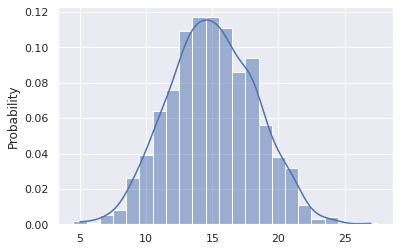

In [63]:
p = 0.3
n = 50
bing = bin_gen(p,n)
N = 1000

values = [next(bing) for i in range(N)]
sns.histplot(data = values, kde = True, kde_kws = {"bw_adjust" : 1}, discrete = True, stat = 'probability')
del p, n, bing, N, values

**Item 2**

Python generator of geometric random variable. Able to generate infinitely.

In [64]:
def geom_gen(p):
    bg = bern_gen(p)
    while True:
        sum = 0
        while not next(bg):
            sum += 1
        yield sum

Visualization of geometric distribution.

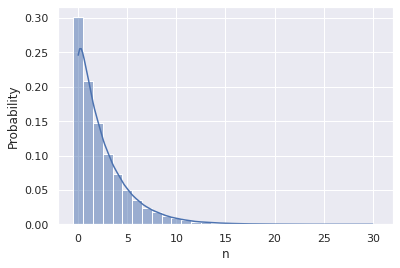

In [65]:
n = 100000
p = 0.3
gg = geom_gen(p)

values = {"n" : [next(gg) for i in range(n)]}
sns.histplot(data = pd.DataFrame(values), x = "n", kde = True, kde_kws = {"bw_adjust" : 2}, discrete = True, stat = 'probability')

del n, p, gg, values

Representation of geometric distribution memoryless property:  $\mathbb{P}(\mathbb{X} > m + n \, | \, \mathbb{X} \geq m) = \mathbb{P}(\mathbb{X} > n) $.  
(Previous cell execution required)

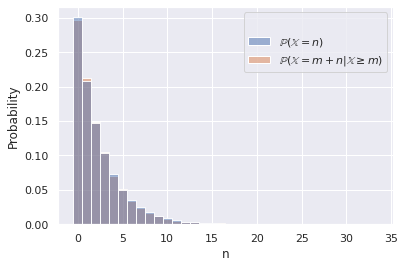

In [66]:
m = 5
n = 100000
p = 0.3
gg = geom_gen(p)

values = {"n" : [next(gg) for i in range(n)]}

values[" "] = r'$\mathbb{P}(\mathbb{X} = n)$'

cutted_values = {"n" : [value - m for value in values["n"] if value >= m]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = m + n | \mathbb{X} \geq m)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "n", hue = " ", discrete = True, stat = "probability", common_norm = False)

del n, m, p, gg, values, cutted_values, df_new_values

**Item 3**

Trajectory of $ Y(i) = \dfrac{X_1 + X_2 + \dots + X_i}{\sqrt{n}} $, where $ \mathbb{P}(X_i = 1) = \mathbb{P}(X_i = -1) = \dfrac{1}{2}, \quad i = 1, \dots, n $

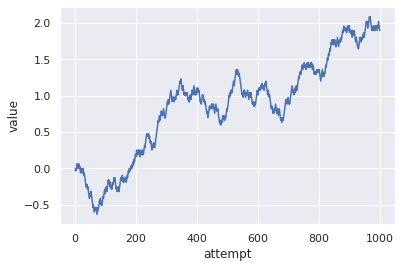

In [67]:
rng = np.random.default_rng()

n = 1000
df = pd.DataFrame(dict(attempt = np.arange(1, n + 1), value = rng.choice(np.array([-1, 1]), n).cumsum() / math.sqrt(n)))
sns.lineplot(x = "attempt", y = "value", data = df)
del rng, n, df

### Task 2

**Item 1**

Python generator for Cantor random variable. Generates list with random variable value and distrubution function at this point.

In [68]:
def cantor_gen(eps):
    bg = bern_gen(0.5)
    n = math.ceil(- math.log(eps, 3))
    while True:
        rand_val = 0
        dis_func = 0
        for i in np.arange(1,n + 1):
            bern = next(bg)
            rand_val += 2 / 3**i * bern
            dis_func += 1 / 2**i * bern    
        yield [rand_val, dis_func]

Kolmogorov distribution function. $ K = 1 + 2 \displaystyle\sum_{k = 1}^{\infty}(-1)^k e^{-2k^2x^2} $

In [69]:
def K(x):
    n = 10000
    sum = 0
    for k in np.arange(1, n + 1):
        sum += (-1)**k * math.e ** (-2 * k**2 * x**2)
    return 1 + 2 * sum

Kolmogorov criteria function. Accepts vector with values of theoretical distribution function in selected points `dist_function` and significance level `alpha`. $D_n $ here is computed using formula: $ D_n(x_1, \dots, x_n) = \displaystyle\max_{1 \le i \le n} \left\{ \dfrac{i}{n} - F(x_{(i)}), F(x_{(i)}) - \dfrac{i - 1}{n} \right\}. $  

In [70]:
def kolmogorov(dist_function, alpha):
    n = dist_function.size
    sorted_dist_function = sorted(dist_function)
    maxes = np.zeros(n)
    for i in np.arange(1, n + 1):
        maxes[i - 1] = max(i / n - sorted_dist_function[i - 1], sorted_dist_function[i - 1] - (i - 1)/n)
    D_n = max(maxes)

    if 1 - K(math.sqrt(n) * D_n) > alpha:
        return True
    else:
        return False

Distribution function of generated Cantor random variable and verification using Kolmogorov criteria.

accordance: 0.94 %


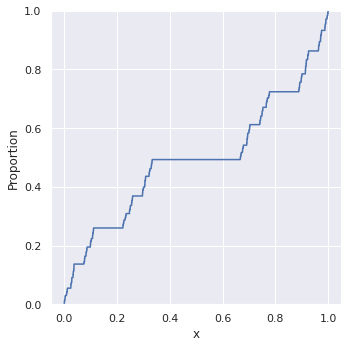

In [71]:
N = 100
n = 1000
cg = cantor_gen(0.0001)
selection = np.zeros(n)
dist_function = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    for i in range(n):
        new_cantor_vec = next(cg)
        selection[i] = new_cantor_vec[0]
        dist_function[i] = new_cantor_vec[1]
    if kolmogorov(dist_function, alpha):
        count += 1
print("accordance:", count / N, "%")

for i in range(n):
    new_cantor_vec = next(cg)
    selection[i] = new_cantor_vec[0]
    dist_function[i] = new_cantor_vec[1]

df = pd.DataFrame({"x" : selection})
sns.displot(data = df, x = "x", kind = "ecdf")

del N, n, cg, selection, new_cantor_vec, dist_function, i, df, alpha, count

**Item 2**

Computation of empirical distribution function of `selection` in `value` point. $ \hat{F}_n (x) = \dfrac{1}{n} \displaystyle\sum_{i = 1}^n \mathbb{I}(x_i < x) $

In [72]:
def F_hat(selection, value):
    number_less = 0
    for val in selection:
        if val <= value:
            number_less += 1
    return number_less / selection.size

Smirnov criteria function. Accepts two selections `x` and `y`, and significance level `alpha`. $ D_{n,m} = \max \left\{ D_{n,m}^+, D_{n,m}^- \right\}$, где $ D_{n,m}^+ = \displaystyle\sup_{x}(\hat{F}_n(x) - \hat{G}_m(x)) = \displaystyle\max_{1 \le i \le n} \left\{ \frac{i}{n} - \hat{G}_m(x_{(i)}) \right\}, D_{n,m}^- = \displaystyle\sup_{x}(\hat{G}_m(x) - \hat{F}_n(x)) = \displaystyle\max_{1 \le j \le m} \left\{ \frac{j}{m} - \hat{F}_n(y_{(j)}) \right\}. $ Uses $ K(x) $ function.

In [73]:
def smirnov(x,y, alpha):
    n = x.size
    m = y.size
    x.sort()
    y.sort()
    maxes_plus = np.zeros(n)
    maxes_minus = np.zeros(m)
    for i in np.arange(1, n + 1):
        maxes_plus[i - 1] = i / n -  F_hat(y, x[i - 1])
    D_plus = max(maxes_plus)

    for i in np.arange(1, m + 1):
        maxes_minus[i - 1] = i/m - F_hat(x, y[i - 1])
    D_minus = max(maxes_minus)

    D_n_m = max(D_plus, D_minus)
    
    if 1 - K(math.sqrt(n * m / (n + m)) * D_n_m) > alpha:
        return True
    else:
        return False

Cheking uniformity of $ X $ and $ 1 - X $ using Smirnov criteria.

uniformity: 0.9 %


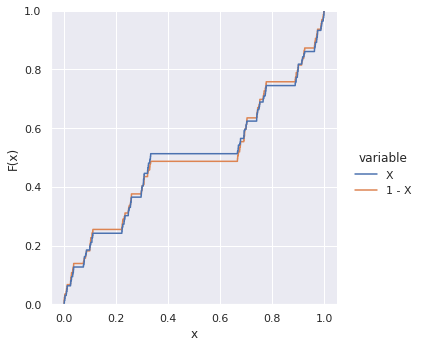

In [107]:
N = 10
n = 1000
cg = cantor_gen(0.0001)
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    for i in range(n):
        x[i] = next(cg)[0]
    y = 1 - x
    if smirnov(x,y, alpha):
        count += 1

print("uniformity:", count / N, "%")

x_values = {"value" : x}
x_values["variable"] = "X"

y_values = {"value" : y}
y_values["variable"] = "1 - X"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

del N, n, cg, x, y, alpha, i, x_values, y_values, df, graph, count

Cheking uniformity of $ X | X \in [0;\dfrac{1}{3}] $ and $ \dfrac{X}{3} $

uniformity: 1.0 %


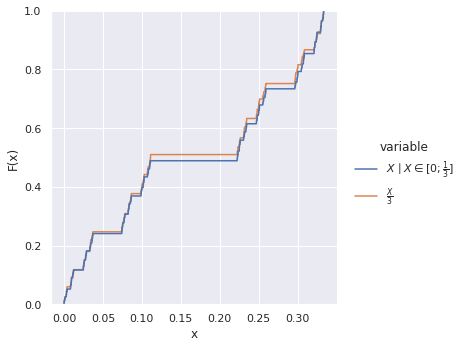

In [108]:
N = 10
n = 1000
cg = cantor_gen(0.0001)
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    for i in range(n):
        x[i] = next(cg)[0]
        y[i] = x[i] / 3
        if x[i] >= 2/3:
            x[i] -= 2/3
    if smirnov(x, y, alpha):
        count += 1
print("uniformity:", count / N, "%")

x_values = {"value" : x}
x_values["variable"] = r"$X \mid X \in [0;\frac{1}{3}]$"

y_values = {"value" : y}
y_values["variable"] = r"$\frac{X}{3}$"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

del N, n, cg, x, y, alpha, i, x_values, y_values, df, graph, count

**Item 3**

Illustration of convergence of sample mean and dispersion values to their theoretical analogues.

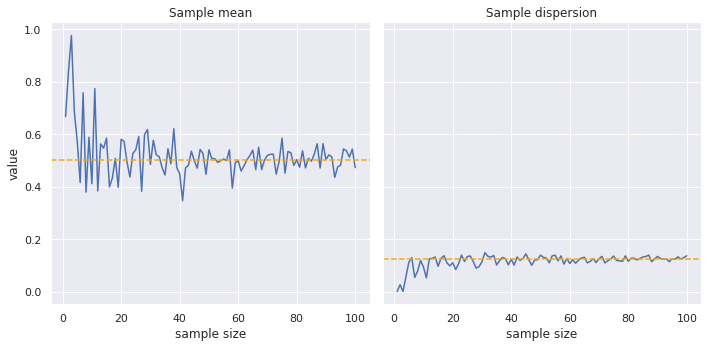

In [76]:
N = 100
cg = cantor_gen(0.001)
E_emp = np.zeros(N)
D_emp = np.zeros(N)
for n in np.arange(1, N + 1):
    selection = [next(cg)[0] for j in range(n)]
    E_n = sum(selection)/n
    D_n = sum((np.array(selection) - E_n)**2) / n
    E_emp[n-1] = E_n
    D_emp[n-1] = D_n

df_E = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : E_emp, "type" : "mean"})
df_D = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : D_emp, "type" : "dispersion"})
df = pd.concat([df_E, df_D], ignore_index = True)

graph = sns.relplot(x = "size", y = "value", data = df, kind = "line", col = "type")
ax1, ax2 = graph.axes[0]
ax1.axhline(0.5, ls='--', color = 'orange')
ax2.axhline(0.125, ls='--', color = 'orange')
graph.set_axis_labels("sample size", "value")
graph.set_titles("Sample {col_name}")

del N, cg, E_emp, D_emp, D_n, E_n, selection, n, df_E, df_D, df, graph, ax1, ax2

### Task 3

**Item 1**

Inversed distribution function of exponential distribution: $F^{-1}(y) = -\dfrac{1}{\lambda} \ln(1 - y) $.

In [77]:
def inv_exp_func(x, lam):
    return -1/lam * np.log(1 - x)

Python generator of exponential distribution with parameter $\lambda = $`lam`.

In [78]:
def exp_gen(lam):
    while True:
        yield inv_exp_func(np.random.random(), lam)

Probability density function of exponential distribution: $ p(x) = \lambda e^{-\lambda x} $

In [79]:
def p_exp(lam, x):
    return lam * np.e**(-lam * x)

Visulization of exponential distrubution.

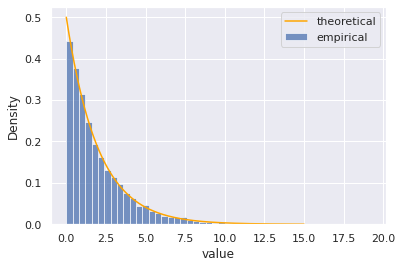

In [80]:
n = 10000
lam = 0.5
eg = exp_gen(lam)

values = {"value" : [next(eg) for i in range(n)]}
graph = sns.histplot(data = pd.DataFrame(values), x = "value", label = "empirical", binwidth = 0.4, stat = 'density')
sns.lineplot(x = np.linspace(0, 15, 1000), y = p_exp(lam, np.linspace(0, 15, 1000)), color = "orange", label = "theoretical", ax = graph)

del n, lam, eg, values, graph

Representation of exponential distribution memoryless property: $ \mathbb{P}(X \ge s + t \mid X \ge t) = \mathbb{P}(X \ge s) $.  
(Previous cell execution required)

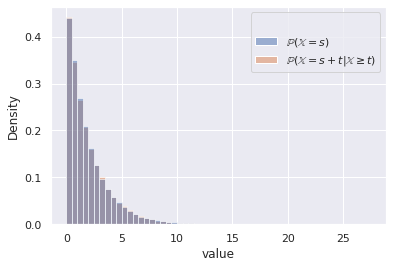

In [81]:
t = 2
n = 100000
lam = 0.5
eg = exp_gen(lam)

values = {"value" : [next(eg) for i in range(n)]}

values[" "] = r'$\mathbb{P}(\mathbb{X} = s)$'

cutted_values = {"value" : [value - t for value in values["value"] if value >= t]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = s + t | \mathbb{X} \geq t)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "value", hue = " ", binwidth = 0.5, stat = "density", common_norm = False)

del n, t, eg, values, cutted_values, df_new_values

Distribution of $ Y = \min(X_1, X_2, \dots, X_n) $, where $ X_i \sim \mathrm{Exp}(\lambda_i) $.

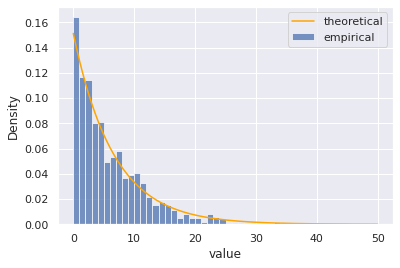

In [82]:
n = 4
N = 1000
lam = [0.1 * np.random.random() for i in range(n)]
eg = [exp_gen(l) for l in lam]
Y = np.zeros(N)
for i in range(N):
    Y[i] = min([next(eg[j]) for j in range(n)])

values = {"value" : Y}
graph = sns.histplot(data = values, x = "value", binwidth = 1, label = "empirical", stat = 'density')
sns.lineplot(x = np.linspace(0, 50, 1000), y = p_exp(sum(lam), np.linspace(0, 50, 1000)), color = "orange", label = "theoretical", ax = graph)

del i, n, N, lam, eg, Y, graph, values

**Item 2**

Poisson distribution generator. Uses exponential distribution generator.

In [83]:
def pois_gen(lam):
    eg = exp_gen(lam)
    while True:
        sum = 0
        count = 0
        while sum < 1:
            sum += next(eg)
            count += 1
        if count > 1:
            yield count - 1
        else:
            yield 0

Poisson density function: $ p(k) = \dfrac{\lambda^k e^{-\lambda}}{k!} $.

In [84]:
def p_pois(lam, k):
    return lam**k * np.e**(-lam) / sp.special.factorial(k)

Visualization of Poisson distribution.

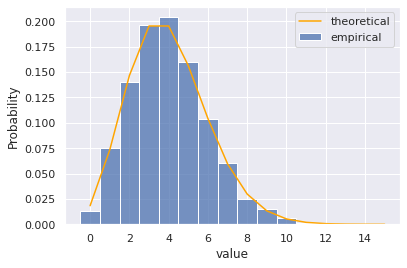

In [85]:
n = 1000
lam = 4
pg = pois_gen(lam)

values = {"value" : [next(pg) for i in range(n)]}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 15, 16), y = p_pois(lam, np.linspace(0, 15, 16)), color = "orange", label = "theoretical", ax = graph)

del n, lam, pg, values, graph

**Item 3**

Generator of Poisson distribution as limit of binominal distribution.  
$ (n = 10000) $

In [86]:
def binlimit_gen(lam):
    n = 10000
    while True:
        bing = bin_gen(lam/n, n)
        yield next(bing)

Binominal distribution with $ n = 10000 $ and $ p = \dfrac{\lambda}{n} $ compared to theoretical Poisson distribution.

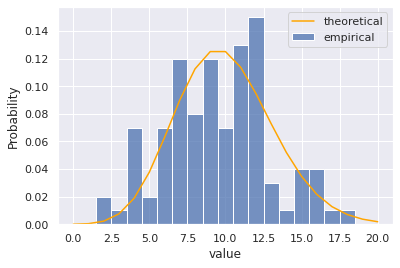

In [87]:
N = 100
lam = 10
blg = binlimit_gen(lam)
values = {"value" : [next(blg) for i in range(N)]}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 20, 21), y = p_pois(lam, np.linspace(0, 20, 21)), color = "orange", label = "theoretical", ax = graph)

del N, lam, blg, values, graph

$ \chi_k^2 $ comulative distribution function of chi-squared distribution. $ F_{\chi_k^2}(x) = \dfrac{\gamma(k/2, x/2)}{\Gamma(k/2)} $

In [88]:
def chi_dist(k, x):
    return sp.special.gammainc(k/2, x/2) / sp.special.gamma(k/x)

Pirson chi-squared criteria. Accepts sample array `values`, density values in sample points `density_func` and significance level `alpha`. Statistic: $ X_n^2 = n \displaystyle\sum_{j = 1}^N \dfrac{1}{p_j^0}(\hat{p}_j - p_j^0)^2 = \displaystyle\sum_{j = 1}^N \dfrac{(\nu_j - np_j^0)^2}{np_j^0}. $ Prints $ 1 - \mathbb{P}(X_n^2 < X_n^{*2}).$

In [89]:

def pirson(values, density_func, alpha):
    n = values.size
    unique, counts = np.unique(values, return_counts = True)
    N = unique.size
    unique_density_func = np.array([density_func[list(values).index(value)] for value in unique])
    X_n = sum((counts - n * unique_density_func)**2 / (n * unique_density_func))
    if 1 - chi_dist(N - 1, X_n) > alpha:
        return True
    else:
        return False

Creating and verification of sample. 

In [109]:
N = 10
n = 1000
lam = 10
blg = binlimit_gen(lam)
alpha = 0.05

count = 0
for j in range(N):
    values = np.array([next(blg) for i in range(N)])
    if pirson(values, p_pois(lam, values), alpha):
        count += 1
print("accordance:", count / N, "%")

del N, n, lam, blg, alpha, count, j, values

accordance: 1.0 %


**Item 4**

Standart normally-distributed variable generator. $ X = \sqrt{-2 \ln\eta_1} \cos(2 \pi \eta_2) $, where $ \eta_1 $ and $ \eta_2 $ - pair of uniformly distributed variables.

In [3]:
def stand_norm_gen_cos():
    while True:
        yield np.sqrt(-2 * np.log(np.random.random())) * np.math.cos(2 * np.math.pi * np.random.random())

Standart normally-distributed variable generator. $ X = \sqrt{-2 \ln\eta_1} \sin(2 \pi \eta_2) $, where $ \eta_1 $ and $ \eta_2 $ - pair of uniformly distributed variables.

In [92]:
def stand_norm_gen_sin():
    while True:
        yield np.sqrt(-2 * np.log(np.random.random())) * np.math.sin(2 * np.math.pi * np.random.random())

Density function of normal distribution with parameters $ \mu $(`mu`) and $ \sigma $ (`sigma`)

In [93]:
def p_norm(mu, sigma, x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

Density of standart normal distribution generated using pair of uniformly distributed values compared to theoretical density.

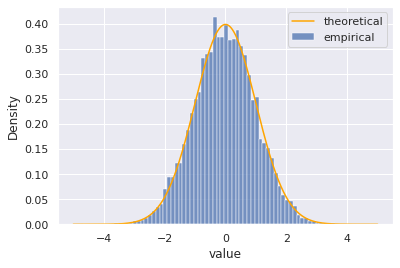

In [94]:
N = 10000
ng = stand_norm_gen_cos()
values = {"value" : [next(ng) for i in range(N)]}
graph = sns.histplot(data = values, x = "value", label = "empirical", stat = 'density')
sns.lineplot(x = np.linspace(-5, 5, 1000), y = p_norm(0, 1, np.linspace(-5, 5, 1000)), color = "orange", label = "theoretical", ax = graph)

del N, ng, values, graph

Computing $ S^2 $ for a given sample.

In [33]:
def get_S(sample):
    n = sample.size
    mean = sum(sample)/n
    S = sum((sample - mean)**2)/(n - 1)
    return S

Fisher criteria. Accepts two samples `sample_1` and `sample_2` to find out if their variances are equal and significance level `alpha`. Statistic: $S_1^2 / S_2^2 \sim F_{k_1, k_2}$, where $ S_1^2 = \dfrac{1}{n - 1} \sum_{i = 1}^{n}(X_i - \overline{X})^2, \quad S_2^2 = \dfrac{1}{m - 1} \sum_{i = 1}^{m}(Y_i - \overline{Y})^2 $

In [96]:
def fisher(sample_1, sample_2, alpha):
    S_1 = get_S(sample_1)
    S_2 = get_S(sample_2)
    n = sample_1.size
    m = sample_2.size
    if (sp.stats.f.cdf(S_1/S_2, n-1, m-1) < alpha/2) | (sp.stats.f.cdf(S_1/S_2, n-1, m-1) > 1 - alpha/2):
        return False
    else:
        return True

Creation of samples and verification of variances equalness.

In [110]:
N = 100
n = 1000
ng_sin = stand_norm_gen_sin()
ng_cos = stand_norm_gen_cos()
alpha = 0.1
count = 0
for i in range(N):
    sample_1 = np.array([next(ng_sin) for i in range(n)])
    sample_2 = np.array([next(ng_cos) for i in range(n)])
    if fisher(sample_1, sample_2, alpha):
        count += 1
print("variances equalness:", count / N, "%")

del N, n, ng_sin, ng_cos, alpha, count, i, sample_1, sample_2

variances equalness: 0.93 %


Student criteria. Accepts two samples `sample_1` and `sample_2` to find out if their mean values are equal and significance level `alpha`. Statistic: $ T = \left( \overline{X} - \overline{Y} \right) \left/ \left( S_{tot} \sqrt{\dfrac{1}{n} + \dfrac{1}{m}} \right) \right. = \left. \sqrt{\dfrac{nm}{n + m}} \left(\overline{X} - \overline{Y} \right) \right/ S_{tot} \sim t_{n + m - 2}, $ where $ S_{tot} = \left[(n - 1) S_1^2 + (m - 1) S_2^2 \right] / (n + m -2) $

In [98]:
def student(sample_1, sample_2, alpha):
    S_1 = get_S(sample_1)
    S_2 = get_S(sample_2)
    n = sample_1.size
    m = sample_2.size
    mean_1 = sum(sample_1)/n
    mean_2 = sum(sample_2)/m
    S_tot = ((n - 1) * S_1 + (m - 1) * S_2)/(n + m - 2)
    T = np.sqrt(n * m/(n + m)) * (mean_1 - mean_2) / S_tot
    if (sp.stats.t.cdf(T, n + m - 2) < alpha/2) | (sp.stats.t.cdf(T, n + m - 2) > 1 - alpha/2):
        return False
    else: 
        return True

Creation of samples and verification of mean values equalness.

In [111]:
N = 100
n = 1000
ng_sin = stand_norm_gen_sin()
ng_cos = stand_norm_gen_cos()
alpha = 0.1
count = 0
for i in range(N):
    sample_1 = np.array([next(ng_sin) for i in range(n)])
    sample_2 = np.array([next(ng_cos) for i in range(n)])
    if student(sample_1, sample_2, alpha):
        count += 1
print("mean values equalness:", count / N, "%")

del N, n, ng_sin, ng_cos, alpha, count, i, sample_1, sample_2

mean values equalness: 0.85 %


### Task 4

**Item 1**

Cauchy distribution generator with parameters `a` and `b`.

In [201]:
def cauchy_gen(a, b):
    while True:
        yield a + b * np.tan(np.pi * (np.random.random() - 1/2))

Theoretical Cauchy density function.

In [213]:
def cdf_cauchy(a, b, x):
    return np.arctan((x - a)/b)/np.pi + 1/2 

Visualisation of generated Cauchy sample compared to theretical Cauchy distribution.

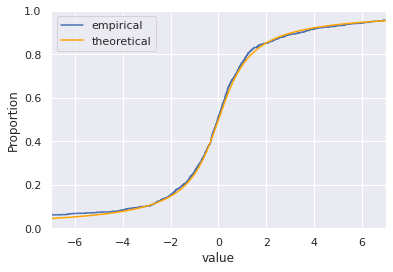

In [102]:
N = 1000
cg = cauchy_gen(0, 1)
values = {"value" : [next(cg) for i in range(N)]}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical")
sns.lineplot(x = np.linspace(-7, 7, 1000), y = cdf_cauchy(0, 1, np.linspace(-7, 7, 1000)), color = "orange", label = "theoretical", ax = graph)
graph.set_xlim([-7, 7])

del N, cg, values, graph

**Item 2**

Cauchy density function.

In [103]:
def p_cauchy(a, b, x):
    return b / (np.pi * ((x - a)**2 + b**2))

Fon-Neyman standart normal distrubution generator.

In [104]:
def fon_neyman_gen():
    k = np.sqrt(2 * np.pi / np.e)
    cg = cauchy_gen(0, 1)
    while True:
        x = next(cg)
        bg = bern_gen(p_norm(0, 1, x) / (k * p_cauchy(0, 1, x)))
        y = next(bg)
        if y == 1:
            yield x

Creation of sample and verification using `sp.stats.probplot()`.

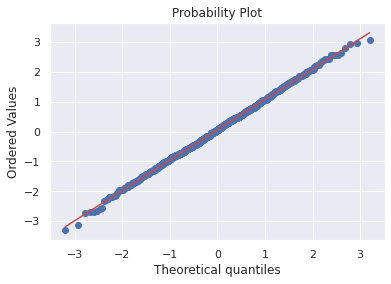

In [105]:
N = 1000
fng = fon_neyman_gen()
values = np.array([next(fng) for i in range(N)])
sp.stats.probplot(values, plot = sns.mpl.pyplot)

del N, fng, values

**Item 3**

Speed comparison of two standart normal distribution generators.

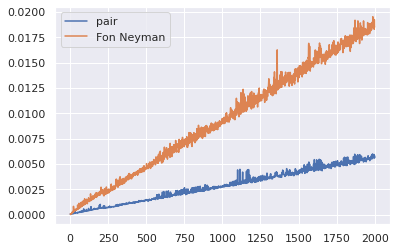

In [117]:
N = 2000
pg = stand_norm_gen_cos()
fng = fon_neyman_gen()
times_pair = np.zeros(N)
times_fon_neyman = np.zeros(N)
for j in np.arange(1, N + 1):
    tic = time.perf_counter()
    sample = [next(pg) for i in range(j)]
    toc = time.perf_counter()
    times_pair[j - 1] = toc - tic

    tic = time.perf_counter()
    sample = [next(fng) for i in range(j)]
    toc = time.perf_counter()
    times_fon_neyman[j - 1] = toc - tic

graph = sns.lineplot(x = np.arange(1, N + 1), y = times_pair, label = "pair")
sns.lineplot(x = np.arange(1, N + 1), y = times_fon_neyman, label = "Fon Neyman", ax = graph)

del N, pg, fng, times_pair, times_fon_neyman

### Task 5

**Item 1**

Law of large numbers.

Text(0, 0.5, 'Sn / n')

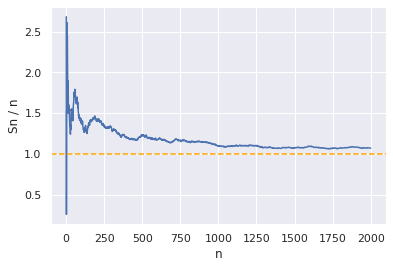

In [24]:
N = 2000
ng = stand_norm_gen_cos()
mu = 1
sigma = 2
sample = np.array([next(ng) for i in range(N)]) * sigma + mu
mean = sample.cumsum() / np.arange(1, N + 1)
graph = sns.lineplot(x = np.arange(1, N + 1), y = mean)
graph.axhline(mu, ls='--', color = 'orange')
graph.set_xlabel("n")
graph.set_ylabel("Sn / n")

del N, ng, mu, sigma, sample, mean, graph

Central limit theorem.

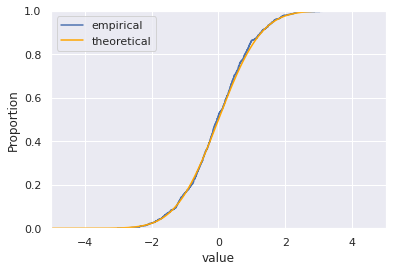

In [197]:
N = 1000
n = 1000
ng = stand_norm_gen_cos()
mu = 1
sigma = 2
X = np.zeros(N)
for i in range(N):
    sample = np.array([next(ng) for j in range(n)])
    sample = sample * sigma + mu
    X[i] = (sum(sample) - mu * n) / (sigma * np.sqrt(n))
values = {"value" : X}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical")
sns.lineplot(x = np.linspace(-5, 5, 1000), y = sp.stats.norm.cdf(np.linspace(-5, 5, 1000)), color = "orange", label = "theoretical", ax = graph)
graph.set_xlim([-5, 5])

del N, n, ng, mu, sigma, X, sample, values, graph, i

**Item 2**

Confidence interval for math expectation.

/tmp/ipykernel_15198/2087429299.py:4: RuntimeWarning: invalid value encountered in double_scalars
  S = sum((sample - mean)**2)/(n - 1)


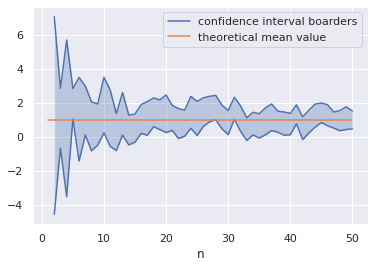

In [199]:
N = 50
ng = stand_norm_gen_cos()
mu = 1
sigma = 2
alpha = 0.05
lower_boarder = np.zeros(N)
upper_boarder = np.zeros(N)
Mean = np.zeros(N)
for n in range(N):
    sample = np.array([next(ng) for i in range(n + 1)])
    sample = sample * sigma + mu
    mean = sum(sample) / (n + 1)
    S = np.sqrt(get_S(sample))
    lower_boarder[n] = mean - sp.stats.t.ppf(1 - alpha/2, n) * S / np.sqrt(n)
    upper_boarder[n] = mean + sp.stats.t.ppf(1 - alpha/2, n) * S / np.sqrt(n)
    Mean[n] = mean
graph = sns.lineplot(x = np.arange(1, N + 1), y = upper_boarder, color = sns.color_palette()[0], label = "confidence interval boarders")
sns.lineplot(x = np.arange(1, N + 1), y = lower_boarder)
sns.lineplot(x = np.arange(1, N + 1), y = mu * np.ones(N), label = "theoretical mean value")
graph.fill_between(np.arange(1, N + 1), upper_boarder, lower_boarder, alpha = 0.3)
graph.set_xlabel("n")

del N, ng, mu, sigma, alpha, lower_boarder, upper_boarder, Mean, n, S, graph, mean, sample

Confidence interval for variance.

/tmp/ipykernel_15198/2087429299.py:4: RuntimeWarning: invalid value encountered in double_scalars
  S = sum((sample - mean)**2)/(n - 1)


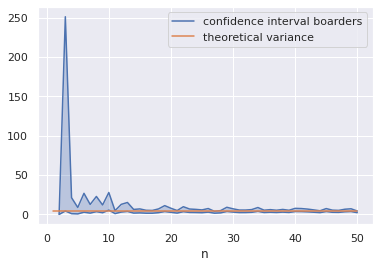

In [200]:
N = 50
ng = stand_norm_gen_cos()
mu = 1
sigma = 2
alpha = 0.1
lower_boarder = np.zeros(N)
upper_boarder = np.zeros(N)
Mean = np.zeros(N)
for n in range(N):
    sample = np.array([next(ng) for i in range(n + 1)])
    sample = sample * sigma + mu
    mean = sum(sample) / (n + 1)
    S = get_S(sample)
    lower_boarder[n] = n * S / sp.stats.chi2.ppf(alpha/2, n)
    upper_boarder[n] = n * S / sp.stats.chi2.ppf(1 - alpha/2, n)
    Mean[n] = mean
graph = sns.lineplot(x = np.arange(1, N + 1), y = upper_boarder, color = sns.color_palette()[0], label = "confidence interval boarders")
sns.lineplot(x = np.arange(1, N + 1), y = lower_boarder)
sns.lineplot(x = np.arange(1, N + 1), y = sigma**2 * np.ones(N), label = "theoretical variance")
graph.fill_between(np.arange(1, N + 1), upper_boarder, lower_boarder, alpha = 0.3)
graph.set_xlabel("n")

del N, ng, mu, sigma, alpha, lower_boarder, upper_boarder, Mean, n, S, graph, mean, sample

**Item 3**

Law of large numbers for Cauchy distribution.

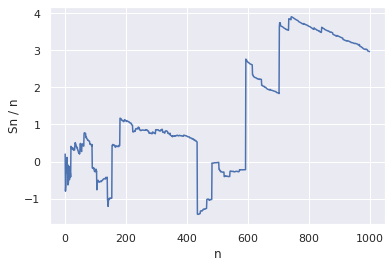

In [211]:
N = 1000
cg = cauchy_gen(0, 1)
sample = np.array([next(cg) for i in range(N)])
mean = sample.cumsum() / np.arange(1, N + 1)
graph = sns.lineplot(x = np.arange(1, N + 1), y = mean)
graph.set_xlabel("n")
graph.set_ylabel("Sn / n")

del N, cg, sample, mean, graph

Cauchy CDF and sample mean CDF. Illustration of $ \overline{X} \sim C(a,b) $

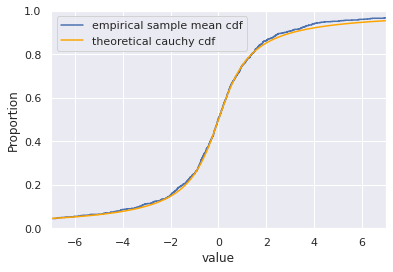

In [233]:
N = 1000
n = 1000
a = 0
b = 1
cg = cauchy_gen(a, b)
X = np.zeros(N)
for i in range(N):
    sample = np.array([next(cg) for j in range(n)])
    X[i] = sum(sample)/n
values = {"value" : X}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical sample mean cdf")
sns.lineplot(x = np.linspace(-7, 7, 1000), y = cdf_cauchy(a, b, np.linspace(-7, 7, 1000)), color = "orange", label = "theoretical cauchy cdf", ax = graph)
graph.set_xlim([-7, 7])

del N, n, cg, a, b, X, sample, values, graph, i

### Task 6

**Item 1**

In [263]:
def f(x):
    x_2 = x[0]**2 * x[1]**2 * x[2]**2 * x[3]**2 * x[4]**2 * x[5]**2 * x[6]**2 * x[7]**2 * x[8]**2 * x[9]**2
    print(x_2)
    return np.sqrt(np.pi**10) * np.exp(-1/(2**7 * x_2)) / x_2

Monte-Carlo method for 	$ \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^\infty \cdots \int\limits_{-\infty}^\infty \frac{e^{-\left(x_1^2 + \ldots + x_{10}^2 + \frac{1}{ 2^7\cdot x_1^2 \cdot \ldots \cdot x_{10}^2}\right)}}{x_1^2 \cdot \ldots \cdot x_{10}^2}dx_1\ldots dx_{10} $ integral.

In [264]:
x = sp.stats.norm.rvs(0, 1/2, 10)
tic = time.perf_counter()
n = 10**2
alpha = 0.05
x_p = sp.stats.norm.ppf(1 - alpha/2)
sample = np.array([f(sp.stats.norm.rvs(0, 1/2, 10)) for i in range(n)])
sigma = np.sqrt(1/n * sum(sample**2) - (1/n * sum(sample))**2)
eps = sigma * x_p / np.sqrt(n)
I = sum(sample)/n
toc = time.perf_counter()
t = toc - tic
print("I:", I, " eps:", eps, " time:", t)

del tic, toc, n, alpha, x_p, sample, sigma, eps, I, t

2.2330504366793442e-05
5.396294526827467e-09
7.506888433372872e-10
1.2815568227249037e-09
2.6499606335805154e-07
2.4308629244786566e-13
6.972869635956184e-10
1.1072634243679839e-10
1.3035924633963438e-12
1.437279737760803e-14
2.569017560743913e-11
6.943490250231054e-15
1.634683817048678e-10
1.6853728869507747e-10
1.0174009203102622e-10
7.969353991962433e-11
2.1440036122052955e-06
2.427241876439151e-10
8.830147731419643e-08
1.50733419061078e-14
4.6696631567806885e-21
3.571830274366292e-09
1.5480818468448718e-13
3.2914675993415614e-11
5.878929964171686e-17
7.244168907929063e-08
7.51106981337516e-12
6.259456883232074e-10
1.8567921746637145e-09
8.979421531640568e-10
3.245614939304847e-13
3.9150554092441225e-11
5.024574732870386e-15
1.4581880559851214e-12
4.1280326670419246e-14
1.857501393012803e-12
6.990334186597144e-12
9.119997405964478e-09
3.4555844116000153e-13
1.1462023794202241e-11
2.5519551065893145e-11
1.2277777623592036e-11
2.1503819356229466e-09
3.2794871284789944e-10
2.1724112940